In [1]:
from IPython.display import FileLink

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(DESeq2)
library(phyloseq)
library(plyr); library(dplyr)
library(ggplot2)
library(doParallel)
library(foreach)
library(tidyr)
library(RColorBrewer)
library(gridExtra)
library(stats)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package:

###These files are from the [assign taxonomy notebook](./Assign_taxonomy.ipynb), [tree notebook](./Tree.ipynb), [merge mappers notebook](./Merge_mappers.ipynb) 

In [4]:
%%R

sample.data = read.table("data/l2fc_table2.csv",
                         sep = ",", header = TRUE)
#sample.data$treatment = as.character(sample.data$treatment)
head(sample.data)

  sparsity_threshold Day Treatment     OTU log2FoldChange           p    Rank1
1               0.55  30        SS OTU.783     -0.3370825 0.996574093 Bacteria
2               0.55  30        SS  OTU.79      0.7598182 0.488986035 Bacteria
3               0.55  30        SS OTU.304      0.4183648 0.808983673 Bacteria
4               0.55  30        SS  OTU.50      0.7289694 0.525236764 Bacteria
5               0.55  30        SS OTU.382      2.9833574 0.000000137 Bacteria
6               0.55  30        SS OTU.465      0.5515994 0.688754034 Bacteria
          Rank2      Rank3        Rank4         Rank5       Rank6
1 Acidobacteria Holophagae      Sva0725          <NA>        <NA>
2 Bacteroidetes Cytophagia Cytophagales Cytophagaceae Flexibacter
3 Bacteroidetes Cytophagia Cytophagales Cytophagaceae Flexibacter
4 Bacteroidetes Cytophagia Cytophagales Cytophagaceae Flexibacter
5 Bacteroidetes Cytophagia Cytophagales Cytophagaceae Flexibacter
6 Bacteroidetes Cytophagia Cytophagales Cytophagace

In [5]:
%%R
l2fc.df.SS.padj = sample.data %>%
    group_by(Treatment) %>%
    mutate(padj = p.adjust(p, method = "BH"))

In [6]:
%%R
l2fc.df.SS.padj

Source: local data frame [1,198 x 15]
Groups: Treatment

   sparsity_threshold Day Treatment      OTU log2FoldChange           p
1                0.55  30        SS  OTU.783     -0.3370825 0.996574093
2                0.55  30        SS   OTU.79      0.7598182 0.488986035
3                0.55  30        SS  OTU.304      0.4183648 0.808983673
4                0.55  30        SS   OTU.50      0.7289694 0.525236764
5                0.55  30        SS  OTU.382      2.9833574 0.000000137
6                0.55  30        SS  OTU.465      0.5515994 0.688754034
7                0.55  30        SS  OTU.162      0.2116710 0.920418761
8                0.55  30        SS OTU.1084      1.1894339 0.136625841
9                0.55  30        SS  OTU.525      1.9020665 0.002101013
10               0.55  30        SS  OTU.985      1.1943492 0.135894247
..                ... ...       ...      ...            ...         ...
Variables not shown: Rank1 (fctr), Rank2 (fctr), Rank3 (fctr), Rank4 (fctr),
  

In [7]:
%%R
##This is to annotate ggplot with the linear equation and r2 values

lm_eqn = function(m) {

  l <- list(a = format(coef(m)[1], digits = 2),
      b = format(abs(coef(m)[2]), digits = 2),
      r2 = format(summary(m)$r.squared, digits = 3));

  if (coef(m)[2] >= 0)  {
    eq <- substitute(italic(y) == b %.% italic(x) + a*","~~italic(r)^2~"="~r2,l)
  } else {
    eq <- substitute(italic(y) == b %.% italic(x) - a*","~~italic(r)^2~"="~r2,l)    
  }

  as.character(as.expression(eq));                 
}

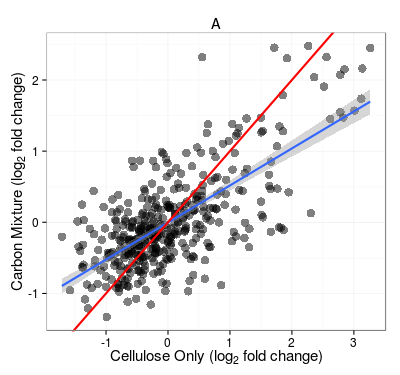

In [8]:
%%R -w 400 -h 375

#r.sq = expression(paste(~~italic(r)^2, "= 0.485", sep = ""))

d = sample.data %>% select(OTU, Treatment, log2FoldChange) %>% spread(Treatment, log2FoldChange)

p1 = ggplot(d, aes(x = SS, y = PS))

p1 = p1 + geom_point(alpha = 0.5, size = 4)

p1 = p1 + stat_smooth(method = "lm", size = 1)

p1 = p1 + labs(x = expression(paste("Cellulose Only (", log[2]," fold change)",sep="")),
            y = expression(paste("Carbon Mixture (", log[2]," fold change)",sep=""))
               )
p1 = p1 + geom_abline(intercept=0, slope=1, color = "red", size = 1)
p1 = p1 + ggtitle("A")
p1 = p1 + theme(plot.title = element_text(hjust = -0.45, vjust=2.12))
#p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p1 = p1 + theme_bw()
p1 = p1 + theme(axis.title.x = element_text(size=15))
p1 = p1 + theme(axis.title.y = element_text(size=15))
p1 = p1 + theme(axis.text.x = element_text(size=12))
p1 = p1 + theme(axis.text.y = element_text(size=12))
#p1 = p1 + annotate("text", x=-0.5, y=1.75, label = "R^{2}==0.485", hjust=1, size=5.75, family="Times", parse=TRUE)


p1

In [9]:
%%R
fit = lm(PS ~ SS, d)
summary(fit)


Call:
lm(formula = PS ~ SS, data = d)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.32447 -0.28757 -0.01146  0.24625  2.03727 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.003112   0.024057  -0.129    0.897    
SS           0.520327   0.026801  19.414   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4827 on 401 degrees of freedom
  (392 observations deleted due to missingness)
Multiple R-squared:  0.4845,	Adjusted R-squared:  0.4832 
F-statistic: 376.9 on 1 and 401 DF,  p-value: < 2.2e-16



In [10]:
%%R
FDR = 0.10

df.sum.sig = sample.data %>%
    group_by(OTU) %>%
    summarize(sum_sig = sum(padj <= FDR, na.rm = TRUE))

In [11]:
%%R
df.sum.sig

Source: local data frame [795 x 2]

        OTU sum_sig
1     OTU.1       0
2    OTU.10       0
3   OTU.100       0
4  OTU.1001       0
5  OTU.1005       0
6  OTU.1006       0
7   OTU.101       0
8  OTU.1010       0
9  OTU.1016       0
10  OTU.102       0
..      ...     ...


Joining by: "OTU"


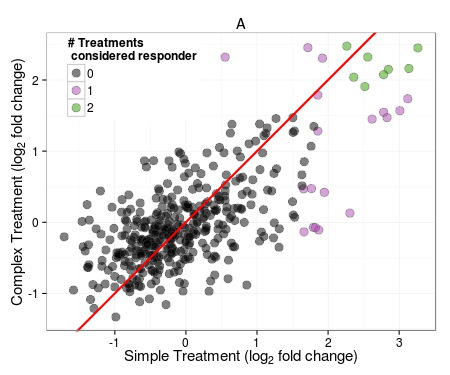

In [12]:
%%R -w 450 -h 375

colours = c("black", "#ac4aaf", "#339900")

p2 = ggplot(left_join(d, df.sum.sig), aes(x = SS, y = PS, fill = factor(sum_sig)))

p2 = p2 + geom_point(shape = 21, alpha = 0.5, size = 4, color = "gray33")

p2 = p2 + scale_fill_manual(values=colours)

p2 = p2 + labs(x = expression(paste("Simple Treatment (", log[2]," fold change)",sep="")),
               y = expression(paste("Complex Treatment (", log[2]," fold change)",sep="")),
               fill = "# Treatments\n considered responder")

p2 = p2 + ggtitle("A")

p2 = p2 + theme_bw()

p2 = p2 + theme(axis.title.y = element_text(size=15),
                axis.title.x = element_text(size=15),
                axis.text.x = element_text(size=12),
                axis.text.y = element_text(size=12))

p2 = p2 + theme(legend.title = element_text(size = 12),
                legend.text = element_text(size = 12),
                legend.position=c(0.22,0.85))

p2 = p2 + geom_abline(intercept=0, slope=1, color = "red", size = 1)

p2

In [13]:
%%R
df = left_join(d, df.sum.sig)
df.noresp = subset(df, (sum_sig == "0"))

Joining by: "OTU"


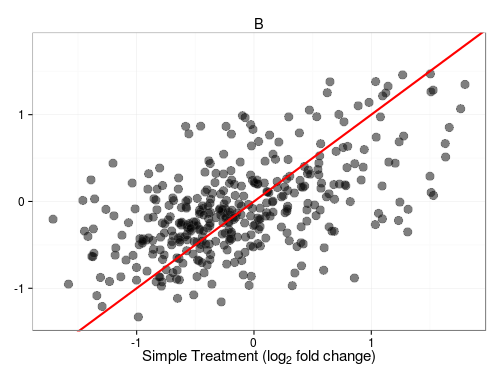

In [14]:
%%R -w 500 -h 375

colours = c("black", "#ac4aaf", "#339900")

p4 = ggplot(df.noresp, aes(x = SS, y = PS, fill = factor(sum_sig)))

p4 = p4 + geom_point(shape = 21, alpha = 0.5, size = 4, color = "gray33")

p4 = p4 + scale_fill_manual(values=colours)

p4 = p4 + labs(x = expression(paste("Simple Treatment (", log[2]," fold change)",sep="")),
               y = expression(paste("Complex Treatment (", log[2]," fold change)",sep="")))

p4 = p4 + ggtitle("B")

p4 = p4 + theme_bw()

p4 = p4 + theme(axis.title.y = element_blank(),
                axis.title.x = element_text(size=15),
                axis.text.x = element_text(size=12),
                axis.text.y = element_text(size=12))

p4 = p4 + theme(legend.title = element_blank(),
                legend.text = element_blank(),
                legend.position = "none")

p4 = p4 + geom_abline(intercept=0, slope=1, color = "red", size = 1)

p4

In [15]:
%%R
FDR = 0.10

df.rspndrs = read.csv("data/l2fc_table2.csv") %>%
    group_by(OTU, Treatment) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by() %>%
    spread(Treatment, minP)

rspnse = function(x) {
    ifelse(sum(x <= FDR, na.rm = TRUE) == 2, "Both", ifelse(!is.na(x[1]), "Simple", "Complex"))
}

df.rspndrs$rspnse = apply(df.rspndrs[,c("SS", "PS")], 1, rspnse)

df.rspndrs = df.rspndrs %>% select(OTU, rspnse)

df.rspndrs

Source: local data frame [39 x 2]

        OTU  rspnse
1  OTU.1023 Complex
2  OTU.1087 Complex
3   OTU.114  Simple
4   OTU.119 Complex
5   OTU.120 Complex
6  OTU.1414  Simple
7   OTU.169  Simple
8    OTU.17  Simple
9   OTU.185    Both
10   OTU.19  Simple
..      ...     ...


In [16]:
%%R
df_all = read.csv("data/l2fc_table2.csv")
head(df_all)

  sparsity_threshold Day Treatment     OTU log2FoldChange           p    Rank1
1               0.55  30        SS OTU.783     -0.3370825 0.996574093 Bacteria
2               0.55  30        SS  OTU.79      0.7598182 0.488986035 Bacteria
3               0.55  30        SS OTU.304      0.4183648 0.808983673 Bacteria
4               0.55  30        SS  OTU.50      0.7289694 0.525236764 Bacteria
5               0.55  30        SS OTU.382      2.9833574 0.000000137 Bacteria
6               0.55  30        SS OTU.465      0.5515994 0.688754034 Bacteria
          Rank2      Rank3        Rank4         Rank5       Rank6
1 Acidobacteria Holophagae      Sva0725          <NA>        <NA>
2 Bacteroidetes Cytophagia Cytophagales Cytophagaceae Flexibacter
3 Bacteroidetes Cytophagia Cytophagales Cytophagaceae Flexibacter
4 Bacteroidetes Cytophagia Cytophagales Cytophagaceae Flexibacter
5 Bacteroidetes Cytophagia Cytophagales Cytophagaceae Flexibacter
6 Bacteroidetes Cytophagia Cytophagales Cytophagace

In [17]:
%%R
#goal - dataframe with PS and SS l2fc values as columns in order to assign them at axis in the plot, 
#and to color the data points by response type 
# this is so I can do a linear regression analysis of just responders for this experiment
d2 = df_all %>%
    select(OTU, Treatment, log2FoldChange) %>%
    spread(Treatment, log2FoldChange) 

d2 = left_join(df.rspndrs, d2) %>% na.omit

d2

Joining by: "OTU"
Source: local data frame [26 x 4]

        OTU  rspnse          PS       SS
1   OTU.114  Simple  1.56975501 3.008842
2  OTU.1414  Simple -0.10699614 1.868864
3    OTU.17  Simple -0.07082457 1.794171
4   OTU.185    Both  2.45121472 3.263674
5    OTU.19  Simple  1.28225616 1.856506
6    OTU.20  Simple -0.13466409 1.661633
7   OTU.204 Complex  2.30654155 1.920706
8   OTU.206  Simple  0.12995008 2.307368
9  OTU.2192  Simple  1.73786047 3.120612
10 OTU.2294  Simple  0.47090766 1.654978
..      ...     ...         ...      ...


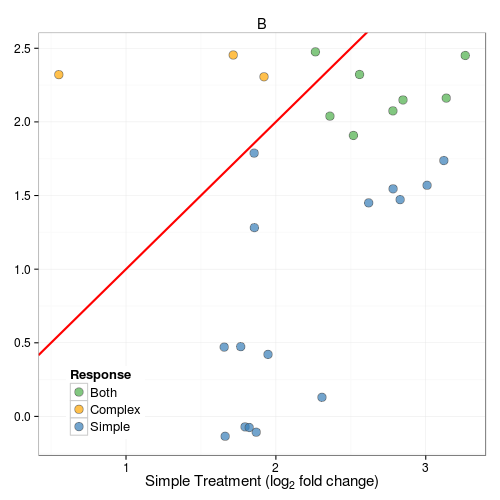

In [18]:
%%R -w 500 -h 500

colours = c("#4daf4a", "orange", "#377eb8")

p3 = ggplot(d2, aes(y = PS, x = SS, fill = rspnse))

p3 = p3 + geom_point(shape = 21, alpha = 0.7, size = 4, color = "gray33")

p3 = p3 + scale_fill_manual(values = colours)

p3 = p3 + geom_abline(intercept=0, slope=1, color = "red", size = 1)

#p3 = p3 + stat_smooth(method = "lm", aes(group = 1), se = FALSE, colour="black", show_guide=FALSE, size = 1)

p3 = p3 + labs(x = expression(paste("Simple Treatment (", log[2]," fold change)",sep="")),
            y = "Complex Substrate, l2fc", 
            fill = "Response")

p3 = p3 + ggtitle("B")

p3 = p3 + theme_bw()
p3 = p3 + theme(axis.title.y = element_blank())
p3 = p3 + theme(axis.title.x = element_text(size=15))
p3 = p3 + theme(axis.text.x = element_text(size=12))
p3 = p3 + theme(axis.text.y = element_text(size=12))
p3 = p3 + theme(legend.title = element_text(size = 13), legend.text = element_text(size = 13))
#p3 = p3 + annotate("text", x=2.5, y=0.5, label = "R^{2}==0.084", hjust=-0.1, size=5.75, family="Times", parse=TRUE)
#p3 = p3 + theme(legend.position=c(0.2,0.8))
p3 = p3 + theme(legend.position=c(0.15,0.125))

p3

In [19]:
%%R
int.df = read.csv("data/interaction.csv")

Joining by: "OTU"


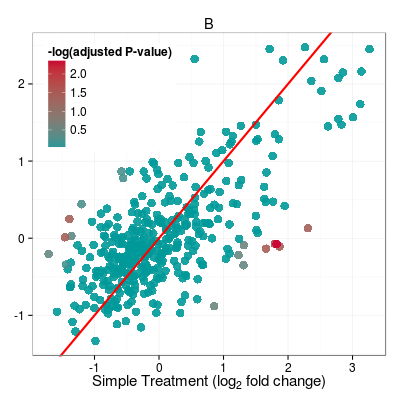

In [20]:
%%R -w 400 -h 400

#r.sq = expression(paste(~~italic(r)^2, "= 0.485", sep = ""))

d = sample.data %>% select(OTU, Treatment, log2FoldChange) %>% spread(Treatment, log2FoldChange) %>%
    left_join(int.df)

p5 = ggplot(d, aes(x = SS, y = PS, color = -log(int.padj)))

p5 = p5 + geom_point(alpha = 0.9, size = 4)

#p1 = p1 + stat_smooth(method = "lm", size = 1)

p5 = p5 + labs(x = expression(paste("Simple Treatment (", log[2]," fold change)",sep="")),
               y = expression(paste("Complex Treatment (", log[2]," fold change)",sep="")),
               color = "-log(adjusted P-value)")
p5 = p5 + geom_abline(intercept=0, slope=1, color = "red", size = 1)
p5 = p5 + ggtitle("B")
p5 = p5 + theme(plot.title = element_text(hjust = -0.45, vjust=2.12))
#p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p5 = p5 + scale_color_gradientn(colours = c("#009999", "#CC0033"))

p5 = p5 + theme_bw()
p5 = p5 + theme(axis.title.x = element_text(size=15),
                axis.title.y = element_blank(),
                axis.text.x = element_text(size=12),
                axis.text.y = element_text(size=12))
p5 = p5 + theme(legend.title = element_text(size = 12),
                legend.text = element_text(size = 12),
                legend.position=c(0.22,0.8))
#p5 = p5 + guides(color = guide_legend(title.position = "right", title.hjust = 2, title.vjust=2.12))
#p1 = p1 + annotate("text", x=-0.5, y=1.75, label = "R^{2}==0.485", hjust=1, size=5.75, family="Times", parse=TRUE)


p5

NULL


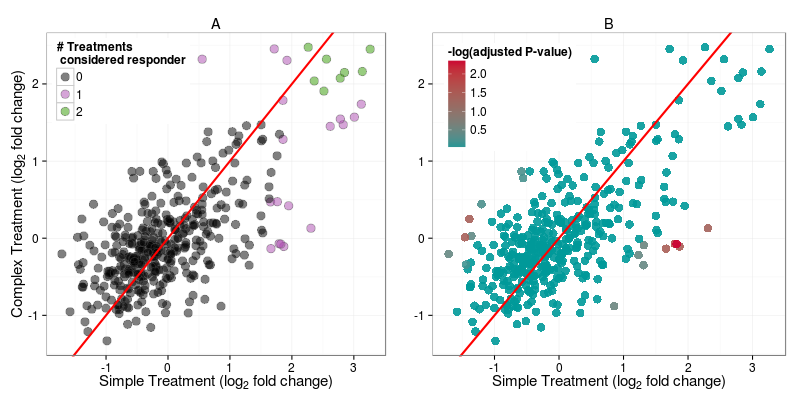

In [21]:
%%R -w 800 -h 400

p.combined = grid.arrange(p2, p5, widths = c(1, 1), heights = c(1,1), ncol = 2)

p.combined

In [22]:
%%R
pdf("figs/linreg_3panel.pdf", w = 12, h = 5.5)
print(grid.arrange(p2, p5, widths = c(1, 1), heights = c(1,1), ncol = 2))
dev.off()

NULL
png 
  2 


In [23]:
%%R
png("figs/linreg_3panel.png", w = 12, h = 5.5, units = "in", res = 600)
print(grid.arrange(p2, p5, widths = c(1, 1), heights = c(1,1), ncol = 2))
dev.off()

NULL
png 
  2 


In [24]:
FileLink("figs/linreg_3panel.pdf")

/home/ashley/single_substrate/figs/linreg_3panel.pdf

In [25]:
FileLink("figs/linreg_3panel.png")

/home/ashley/single_substrate/figs/linreg_3panel.png